# PRACTICA DE DEEP LEARNING. IMAGE CAPTIONING

## Experimentos:


*  Redes CNN:    1) VGG16         2) ResNet
*  Redes RNN:    1) LSTM           2) GRU

Descargamos el dataset

In [1]:
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!unzip -o Flickr8k_text.zip

--2019-02-03 08:11:03--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2340801 (2.2M) [application/zip]
Saving to: ‘Flickr8k_text.zip’

Flickr8k_text.zip   100%[===================>]   2.23M   661KB/s    in 3.5s    

2019-02-03 08:11:07 (661 KB/s) - ‘Flickr8k_text.zip’ saved [2340801/2340801]

Archive:  Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              


Vamos a preparar nuestros datos. Para ello, vamos a crear algunas funciones auxiliares:

In [0]:
# Función para cargar las imágenes
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = 'Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

In [3]:
# Miramos la longitud del archivo doc
len(doc)

3395237

In [4]:
doc[:255]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_'

In [3]:
# extraemos las descripciones para las imagenes
def load_descriptions(doc):
    mapping = dict()
    # Procesamos las líneas. Dividimos el texto en líneas
    for line in doc.split('\n'):
        # Dividimos las líneas por espacios en blanco
        tokens = line.split()
        if len(line) < 2:
            continue
        # Tomamos el primer token como el image id, el resto como descripción
        image_id, image_desc = tokens[0], tokens[1:]
        # Eliminamos las extensión del archivo image id
        image_id = image_id.split('.')[0]
        # Convertimos la descripción de tokens a string
        image_desc = ' '.join(image_desc)
        # Almacenamos la primera descripción para cada imagen
        if image_id not in mapping:
            mapping[image_id] = image_desc
    return mapping
 
# Analizamos las descripciones
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Vamos a limpiar las descripciones. Necesitamos:
* convertir todas las palabras a minúsculas
* quitar los signos de puntuación 
* quitar también las palabras que son de un solo caracter: por ejemplo, "a". Tened en cuenta que el dataset está en inglés.

In [4]:
import string

# Definimos la función limpiar descripciones
def clean_descriptions(descriptions):
    # Preparamos las tabla de traducción para eliminar los signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    for key, desc in descriptions.items():
        # tokenize. Dividimos en palabras
        desc = desc.split()
        # Convertimos a minusculas
        desc = [word.lower() for word in desc]
        # Eliminamos los signos de puntuación de cada token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # store as string. Los almacenamos como string
        descriptions[key] =  ' '.join(desc)

# clean descriptions. Limpiamos las descripciones
clean_descriptions(descriptions)
# summarize vocabulary. Resumen de vocabulario
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 4484


In [0]:
# Vemos las keys de vocabulary
descriptions.keys()

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [0]:
vocabulary

{'song',
 'tongues',
 'shorter',
 'hands',
 'fight',
 'looking',
 'hopes',
 'claus',
 'ascends',
 'machines',
 'muddy',
 'ridge',
 'graffiticovered',
 'corgis',
 'tackled',
 'panting',
 'eyeing',
 'umbrellas',
 'wire',
 'trained',
 'marching',
 'sell',
 'flight',
 'athlete',
 'soldiers',
 'fronmt',
 'kangaroo',
 'dumped',
 'wade',
 'splits',
 'swan',
 'individual',
 'see',
 'lionist',
 'soccer',
 'follow',
 'european',
 'help',
 'dragon',
 'shades',
 'wilderness',
 'asking',
 'behind',
 'sport',
 'cutting',
 'them',
 'goats',
 'jackets',
 'burst',
 'misses',
 'dune',
 'painted',
 'infant',
 'halfcompleted',
 'toothbrush',
 'dancing',
 'dives',
 'put',
 'pumps',
 'greyhound',
 'eyebrow',
 'extended',
 'wounded',
 'pelicans',
 'gin',
 'bubbles',
 'fast',
 'firedancer',
 'beach',
 'ferry',
 'engulfed',
 'cellphone',
 'swear',
 'retrieving',
 'handgun',
 'dolphin',
 'hay',
 'boarders',
 'volleyball',
 'communal',
 'prisoner',
 'trade',
 'fishers',
 'diver',
 'opposing',
 'earpiece',
 'noth

In [0]:
# guardamos las descripciones a un archivo, uno por línea
# save descriptions to file, one per line
def save_doc(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
save_doc(descriptions, 'descriptions.txt')

In [8]:
type(descriptions)

dict

In [0]:
descriptions.keys()

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [0]:
descriptions.values()

dict_values(['child in pink dress is climbing up set of stairs in an entry way', 'black dog and spotted dog are fighting', 'little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'man lays on bench while his dog sits by him', 'man in an orange hat starring at something', 'child playing on rope net', 'black and white dog is running in grassy garden surrounded by white fence', 'dog shakes its head near the shore red ball next to it', 'boy smiles in front of stony wall in city', 'black dog leaps over log', 'brown and white dog is running through the snow', 'man in hat is displaying pictures next to skier in blue hat', 'collage of one person climbing cliff', 'brown dog chases the water from sprinkler on lawn', 'dog prepares to catch thrown object in field with nearby cars', 'black and white dog jumping in the air to get toy', 'child and woman are at waters edge in big city', 'couple and an infant being held by the male sitting next to pond with near by strol

Preparación de las fotos

In [0]:
# Eliminamos el dataset para evitar problemas
rm -rf Flickr8k_Dataset.zip*    

In [0]:
rm -rf Flickr8k_text.zip.1

In [6]:
ls -la

total 12780
drwxr-xr-x 1 root root    4096 Feb  3 08:12 ./
drwxr-xr-x 1 root root    4096 Feb  3 08:08 ../
drwxr-xr-x 4 root root    4096 Jan 31 17:14 .config/
-rw-r--r-- 1 root root 2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 root root  587144 Feb  3 08:12 descriptions.txt
-rw-r--r-- 1 root root  346674 Oct 14  2013 ExpertAnnotations.txt
-rw-r--r-- 1 root root   25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root 3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root   25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 root root 2340801 Oct 28  2013 Flickr8k_text.zip
-rw-r--r-- 1 root root 3395237 Oct 14  2013 Flickr8k.token.txt
-rw-r--r-- 1 root root  154678 Oct 10  2013 Flickr_8k.trainImages.txt
drwxrwxr-x 2 root root    4096 Oct 14  2013 __MACOSX/
-rw-r--r-- 1 root root    1821 Oct 14  2013 readme.txt
drwxr-xr-x 1 root root    4096 Jan 31 17:15 sample_data/


In [8]:
# Descargamos el dataset
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip   
!unzip -q Flickr8k_Dataset.zip

--2019-02-03 08:13:04--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi 100%[===================>]   1.04G  2.43MB/s    in 8m 43s  

2019-02-03 08:21:47 (2.03 MB/s) - ‘Flickr8k_Dataset.zip’ saved [1115419746/1115419746]



In [9]:
# comprobamos si se han descomprimido
!ls -ls

total 1102508
   2852 -rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
    576 -rw-r--r-- 1 root root     587144 Feb  3 08:12 descriptions.txt
    340 -rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
    452 drwxr-xr-x 2 root root     458752 Oct  3  2012 Flicker8k_Dataset
1089288 -rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
     28 -rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
   3172 -rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
     28 -rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
   2292 -rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
   3316 -rw-r--r-- 1 root root    3395237 Oct 14  2013 Flickr8k.token.txt
    152 -rw-r--r-- 1 root root     154678 Oct 10  2013 Flickr_8k.trainImages.txt
      4 drwxrwxr-x 3 root root       4096 Feb  3 08:21 __MACOSX
      4 -rw-r--r-- 1 root root       1821 Oct 14  2013 readme.txt
      4 d

In [10]:
# Librería de las barras de progreso
!pip install tqdm        

## Experimento 1: ResNet 50 - LSTM


In [13]:
# Importamos las librerías que necesitamos
from os import listdir
from pickle import load, dump
from tqdm import tqdm
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu    
from keras.preprocessing.text import Tokenizer        
from keras.preprocessing.sequence import pad_sequences       
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Embedding, GRU
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D

Using TensorFlow backend.


In [14]:
# Empezamos con la extracción de características
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))      
    #model = VGG16(include_top=False, input_tensor=in_layer)
    model = ResNet50(include_top=False, weights='imagenet', input_tensor=in_layer)
    #model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    # extract features from each photo.
    features = dict()

    files_in_directory = listdir(directory)     
    n_images = len(files_in_directory)
    for i, name in tqdm(enumerate(files_in_directory)): 
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array. Convertimos las imagenes a array
        image = img_to_array(image)
        # reshape data for the model. Añadimos la dimensión del batch
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model. Preprocesar la imagen
        image = preprocess_input(image)
        # get features. Le decimos que coja la imagen, la pase por la cnn y nos dé las predicciones. En feature tendremos el conjunto de mapas de activaciones
        feature = model.predict(image, verbose=0)
        # get image id. Miramos el id de la imagen
        image_id = name.split('.')[0]
        # store feature. Se lo metemos en el diccionario
        features[image_id] = feature
        # print('{} / {} > {}'.format(i, n_images, name))
    return features          


# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))     

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


0it [00:00, ?it/s]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

8091it [04:12, 32.24it/s]


Extracted Features: 8091


In [16]:
!ls -lah feat*

-rw-r--r-- 1 root root 3.1G Jan 28 14:28 features.pkl


In [0]:
from pickle import load

# load doc into memory. Cargamos nuestro documento limpio
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Carga de los id de las fotos
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # De las que no esten vacías cogemos el identificador
        identifier = line.split('.')[0]        
        dataset.append(identifier)
        # Obtenemos un set con cada uno de los identificadores de las fotos que hay
    return set(dataset)                                     


# load clean descriptions into memory. Esta función carga las descripciones limpias
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space. Divide las líneas por espacio
        tokens = line.split()
        # split id from description. Se queda como primer elemento como id y con todos los demás que son la descripción de imagen
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set. Si el id de la imagen aparece en el dataset
        if image_id in dataset:
            # store. Añadimos la descripción
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

# load photo features. Carga las características para una determinada foto
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features


In [18]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000


In [19]:
# Ahora codificamos nuestras descripciones a números
from keras.preprocessing.text import Tokenizer

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4485


In [0]:
# Creamos las secuencias con las que se creará el modelo

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y) . y: etiqueta
    return [Ximages, XSeq, y]

In [0]:
# define the captioning model. Definimos: vocab_size --> tño de nuestro vocabulario, max_length --> tño max de las descripciones que queremos que genere
def define_model(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(7, 7, 2048))         
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)        
	# embedding. Pasamos de palabras a números. Cosas que entienda la LSTM
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)      
	emb3 = LSTM(256, return_sequences=True)(emb2)      
	emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)   
	# merge inputs
	merged = concatenate([fe3, emb4])    
	# language model (decoder)
	lm2 = LSTM(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
	outputs = Dense(vocab_size, activation='softmax')(lm3)      
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)            
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])         
	print(model.summary())
	return model        

In [0]:
# data generator, intended to be used in a call to model.fit_generator(). Función que se va a encargar de alimentar nuestra red
def data_generator(descriptions, features, tokenizer, max_length, n_step):
# loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = features[image_id][0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]   

In [0]:
# map an integer to a word. Permite mapear de un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image. Genera una descripción para una imagen, en la forma que la red la necesita
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq' 
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)         
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word                          
        # stop if we predict the end of the sequence
        if word == 'endseq':            
            break
    return in_text
 
# evaluate the skill of the model. Función que nos permite evaluar la precisión de nuestro modelo
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score. BLEU es una métrica que se usa en NLP. Mide como de bueno es la predicción
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [24]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'resnet_lstm_100ep'
verbose = 1
n_epochs = 100
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)

print("=============Start Model Fit=========================")
# fit model
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
# evaluate model on training data
train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


print("===========Finish Model Fit =========================")
# store
train_results.append(train_score)
test_results.append(test_score)

print("=============Starting Record train and test results=========================")
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)
print("=============Finish Record train and test results=========================")

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 7, 2048)   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       192850      inpu

In [25]:
!ls -ls

total 4274904
   2852 -rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
    576 -rw-r--r-- 1 root root     587144 Jan 28 14:17 descriptions.txt
    340 -rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
3172436 -rw-r--r-- 1 root root 3248566509 Jan 28 14:28 features.pkl
    408 drwxr-xr-x 2 root root     413696 Jan 28 14:22 Flicker8k_Dataset
1089288 -rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
     28 -rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
   3172 -rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
     28 -rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
   2292 -rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
   3316 -rw-r--r-- 1 root root    3395237 Oct 14  2013 Flickr8k.token.txt
    152 -rw-r--r-- 1 root root     154678 Oct 10  2013 Flickr_8k.trainImages.txt
      4 drwxrwxr-x 3 root root       4096 Jan 28 14:22 __MACOSX
      4

## Experimento 2:  VGG16 - LSTM
![texto alternativo](https://)

In [12]:
# Importamos las librerías que necesitamos
from os import listdir
from pickle import load, dump
from tqdm import tqdm
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu    
from keras.preprocessing.text import Tokenizer        
from keras.preprocessing.sequence import pad_sequences         
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Embedding, GRU
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D

Using TensorFlow backend.


In [15]:
# Empezamos con la extracción de características
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))      
    model = VGG16(include_top=False, input_tensor=in_layer)
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    # extract features from each photo.
    features = dict()

    files_in_directory = listdir(directory)     
    n_images = len(files_in_directory)
    for i, name in tqdm(enumerate(files_in_directory)): 
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array. Convertimos las imagenes a array
        image = img_to_array(image)
        # reshape data for the model. Añadimos la dimensión del batch
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model. Preprocesar la imagen
        image = preprocess_input(image)
        # get features. Le decimos que coja la imagen, la pase por la cnn y nos dé las predicciones. En feature tendremos el conjunto de mapas de activaciones
        feature = model.predict(image, verbose=0)
        # get image id. Miramos el id de la imagen
        image_id = name.split('.')[0]
        # store feature. Se lo metemos en el diccionario
        features[image_id] = feature
        # print('{} / {} > {}'.format(i, n_images, name))
    return features          


# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))     

2it [00:00, 18.14it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

8091it [04:12, 32.08it/s]


Extracted Features: 8091


In [16]:
!ls -lah feat*

-rw-r--r-- 1 root root 3.1G Feb  2 16:53 features.pkl


In [0]:
from pickle import load

# load doc into memory. Cargamos nuestro documento limpio
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Carga de los id de las fotos
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # De las que no esten vacías cogemos el identificador
        identifier = line.split('.')[0]        
        dataset.append(identifier)
        # Obtenemos un set con cada uno de los identificadores de las fotos que hay
    return set(dataset)                                     


# load clean descriptions into memory. Esta función carga las descripciones limpias
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space. Divide las líneas por espacio
        tokens = line.split()
        # split id from description. Se queda como primer elemento como id y con todos los demás que son la descripción de imagen
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set. Si el id de la imagen aparece en el dataset
        if image_id in dataset:
            # store. Añadimos la descripción
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

# load photo features. Carga las características para una determinada foto
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features


In [18]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000


In [20]:
# Ahora codificamos nuestras descripciones a números
from keras.preprocessing.text import Tokenizer

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4485


In [0]:
# Creamos las secuencias con las que se creará el modelo

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y) . y: etiqueta
    return [Ximages, XSeq, y]

In [0]:
# define the captioning model. Definimos: vocab_size --> tño de nuestro vocabulario, max_length --> tño max de las descripciones que queremos que genere
def define_model(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(14, 14, 512))         
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)        
	# embedding. Pasamos de palabras a números. Cosas que entienda la LSTM
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)      
	emb3 = LSTM(256, return_sequences=True)(emb2)      
	emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)   
	# merge inputs
	merged = concatenate([fe3, emb4])    
	# language model (decoder)
	lm2 = LSTM(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
	outputs = Dense(vocab_size, activation='softmax')(lm3)      
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)            
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])         
	print(model.summary())
	return model        

In [0]:
# data generator, intended to be used in a call to model.fit_generator(). Función que se va a encargar de alimentar nuestra red
def data_generator(descriptions, features, tokenizer, max_length, n_step):
# loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = features[image_id][0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]   

In [0]:
# map an integer to a word. Permite mapear de un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image. Genera una descripción para una imagen, en la forma que la red la necesita
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq' 
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)          
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word                           
        # stop if we predict the end of the sequence
        if word == 'endseq':            
            break
    return in_text
 
# evaluate the skill of the model. Función que nos permite evaluar la precisión de nuestro modelo
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score. BLEU es una métrica que se usa en NLP. Mide como de bueno es la predicción
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [22]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'vgg16_lstm_100ep'
verbose = 1
n_epochs = 100
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)

print("=============Start Model Fit=========================")
# fit model
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
# evaluate model on training data
train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


print("===========Finish Model Fit =========================")
# store
train_results.append(train_score)
test_results.append(test_score)

print("=============Starting Record train and test results=========================")
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)
print("=============Finish Record train and test results=========================")

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       192850      inpu

Vamos a hacer una prueba con 50 épocas para posteriormente evaluar el modelo:


In [25]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'vgg16_lstm_50ep'
verbose = 1
n_epochs = 50
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)


# train the model, run epochs manually and save after each epoch
#steps = len(train_descriptions)

	# create the data generator
  #generator = data_generator(train_descriptions, train_features, tokenizer, max_length, steps)

  # fit for one epoch
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_batches_per_epoch), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    
  # save model
model.save('model_' + str(n_epochs) + '.h5')

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 14, 14, 512)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       192850      inpu

In [0]:
model.save('model_' + str(n_epochs) + '.h5')

In [0]:
#rm -rf model_50.h5

In [49]:
ls -la

total 4378400
drwxr-xr-x 1 root root       4096 Feb  2 20:43 ./
drwxr-xr-x 1 root root       4096 Feb  2 16:34 ../
-rw-r--r-- 1 root root    7802308 Feb  2 20:45 11293289843_831b538448_o.jpg
-rw-r--r-- 1 root root      28852 Feb  2 20:32 11293289843_ca9dc6a50f_m.jpg
drwxr-xr-x 4 root root       4096 Jan 31 17:14 .config/
-rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 root root     587144 Feb  2 19:05 descriptions.txt
-rw-r--r-- 1 root root      11829 Feb  2 17:54 example_reducida.jpg
-rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
-rw-r--r-- 1 root root 3248566509 Feb  2 19:16 features.pkl
drwxr-xr-x 2 root root     458752 Feb  2 19:11 Flicker8k_Dataset/
-rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImag

In [0]:
# Importamos las librerías para poder cargar archivos en Google Colab y poder ver las imágenes
from google.colab import files
from IPython.display import Image

In [46]:
# Subimos las imágenes a Google Colab
uploaded = files.upload()

Saving 11293289843_831b538448_o.jpg to 11293289843_831b538448_o.jpg


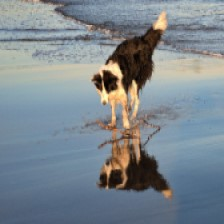

In [79]:
# Visualizamos la imagen cargada
Image ('example_reducida.jpg',
      width = 1200)

In [29]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
  all_features = load(open(filename, 'rb'))
	# filter features
  features = {k: all_features[k] for k in dataset}
  return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)
 
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
  # seed the generation process
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
    yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
    yhat = argmax(yhat)
		# map integer to word
    word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
    if word is None:
      break
		# append as input for generating the next word
    in_text += ' ' + word
		# stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text
 
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()
	# step over the whole set
  for key, desc_list in descriptions.items():
		# generate description
    yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# prepare tokenizer on train set
 
# load training dataset (6K)
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# prepare test set
 
# load test set
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = 'model_50.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 3857
Description Length: 30
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.323062
BLEU-2: 0.146775
BLEU-3: 0.102572
BLEU-4: 0.045447


In [30]:
from keras.preprocessing.text import Tokenizer
from pickle import dump
 
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
		# get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
			# wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
      descriptions[image_id].append(desc)
  return descriptions
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
 
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [34]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
  #model = VGG16()
  in_layer = Input(shape=(224, 224, 3))      
  model = VGG16(include_top=False, input_tensor=in_layer)

	# re-structure the model
  model.layers.pop()
  
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  print(model.summary())
  
	# load the photo
  image = load_img(filename, target_size=(224, 224))
  
	# convert the image pixels to a numpy array
  image = img_to_array(image)
  
	# reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  
	# prepare the image for the VGG model
  image = preprocess_input(image)
	# get features
  feature = model.predict(image, verbose=0)
  return feature

 
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
  in_text = 'startseq'
	# iterate over the whole length of the sequence
  for i in range(max_length):
  	# integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
    yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
    yhat = argmax(yhat)
		# map integer to word
    word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
    if word is None:
      break
		# append as input for generating the next word
    in_text += ' ' + word
		# stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 30
# load the model
model = load_model('model_50.h5')
# load and prepare the photograph
photo = extract_features('example_reducida.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [50]:
# Visualizamos la imagen cargada
Image ('11293289843_831b538448_o.jpg',
      width = 1200)

Output hidden; open in https://colab.research.google.com to view.

In [51]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
  #model = VGG16()
  in_layer = Input(shape=(224, 224, 3))      
  model = VGG16(include_top=False, input_tensor=in_layer)

	# re-structure the model
  model.layers.pop()
  
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  print(model.summary())
  
	# load the photo
  image = load_img(filename, target_size=(224, 224))
  
	# convert the image pixels to a numpy array
  image = img_to_array(image)
  
	# reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  
	# prepare the image for the VGG model
  image = preprocess_input(image)
	# get features
  feature = model.predict(image, verbose=0)
  return feature

 
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
  in_text = 'startseq'
	# iterate over the whole length of the sequence
  for i in range(max_length):
  	# integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
    yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
    yhat = argmax(yhat)
		# map integer to word
    word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
    if word is None:
      break
		# append as input for generating the next word
    in_text += ' ' + word
		# stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 30
# load the model
model = load_model('model_50.h5')
# load and prepare the photograph
photo = extract_features('11293289843_831b538448_o.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Experimento 3: ResNet 50 - GRU

In [15]:
# Importamos las librerías que necesitamos
from os import listdir
from pickle import load, dump
from tqdm import tqdm
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu   
from keras.preprocessing.text import Tokenizer        
from keras.preprocessing.sequence import pad_sequences         
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Embedding, GRU
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D

Using TensorFlow backend.


In [16]:
# Empezamos con la extracción de características
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))      
    model = ResNet50(include_top=False, weights='imagenet', input_tensor=in_layer)
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    # extract features from each photo.
    features = dict()

    files_in_directory = listdir(directory)     
    n_images = len(files_in_directory)
    for i, name in tqdm(enumerate(files_in_directory)): 
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array. Convertimos las imagenes a array
        image = img_to_array(image)
        # reshape data for the model. Añadimos la dimensión del batch
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model. Preprocesar la imagen
        image = preprocess_input(image)
        # get features. Le decimos que coja la imagen, la pase por la cnn y nos dé las predicciones. En feature tendremos el conjunto de mapas de activaciones
        feature = model.predict(image, verbose=0)
        # get image id. Miramos el id de la imagen
        image_id = name.split('.')[0]
        # store feature. Se lo metemos en el diccionario
        features[image_id] = feature
        # print('{} / {} > {}'.format(i, n_images, name))
    return features          


# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb')) 

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
0it [00:00, ?it/s]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

8091it [04:17, 31.30it/s]


Extracted Features: 8091


In [0]:
from pickle import load

# load doc into memory. Cargamos nuestro documento limpio
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Carga de los id de las fotos
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # De las que no esten vacías cogemos el identificador
        identifier = line.split('.')[0]        
        dataset.append(identifier)
        # Obtenemos un set con cada uno de los identificadores de las fotos que hay
    return set(dataset)                                     


# load clean descriptions into memory. Esta función carga las descripciones limpias
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space. Divide las líneas por espacio
        tokens = line.split()
        # split id from description. Se queda como primer elemento como id y con todos los demás que son la descripción de imagen
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set. Si el id de la imagen aparece en el dataset
        if image_id in dataset:
            # store. Añadimos la descripción
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

# load photo features. Carga las características para una determinada foto
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features


In [18]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000


In [20]:
# Ahora codificamos nuestras descripciones a números
from keras.preprocessing.text import Tokenizer

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4485


In [0]:
# Creamos las secuencias con las que se creará el modelo

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y) . y: etiqueta
    return [Ximages, XSeq, y]

In [0]:
# define the captioning model. Definimos: vocab_size --> tño de nuestro vocabulario, max_length --> tño max de las descripciones que queremos que genere
def define_model(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(7, 7, 2048))         
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)        
	# embedding. Pasamos de palabras a números. Cosas que entienda la LSTM
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)      
	emb3 = GRU(256, return_sequences=True)(emb2)      
	emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)   
	# merge inputs
	merged = concatenate([fe3, emb4])    
	# language model (decoder)
	lm2 = GRU(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
	outputs = Dense(vocab_size, activation='softmax')(lm3)      
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)            
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])         
	print(model.summary())
	return model        

In [0]:
# data generator, intended to be used in a call to model.fit_generator(). Función que se va a encargar de alimentar nuestra red
def data_generator(descriptions, features, tokenizer, max_length, n_step):
# loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = features[image_id][0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)] 

In [0]:
# map an integer to a word. Permite mapear de un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image. Genera una descripción para una imagen, en la forma que la red la necesita
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq' 
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)         
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word                           
        # stop if we predict the end of the sequence
        if word == 'endseq':            
            break
    return in_text
 
# evaluate the skill of the model. Función que nos permite evaluar la precisión de nuestro modelo
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score. BLEU es una métrica que se usa en NLP. Mide como de bueno es la predicción
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [25]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'resnet_gru_100ep'
verbose = 1
n_epochs = 100
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)

print("=============Start Model Fit=========================")
# fit model
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
# evaluate model on training data
train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


print("===========Finish Model Fit =========================")
# store
train_results.append(train_score)
test_results.append(test_score)

print("=============Starting Record train and test results=========================")
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)
print("=============Finish Record train and test results=========================")

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 7, 2048)   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       192850      inpu

## Experimento 4: VGG 16 - GRU

In [11]:
# Importamos las librerías que necesitamos
from os import listdir
from pickle import load, dump
from tqdm import tqdm
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu    
from keras.preprocessing.text import Tokenizer        
from keras.preprocessing.sequence import pad_sequences         
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Embedding, GRU
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D

Using TensorFlow backend.


In [12]:
# Empezamos con la extracción de características
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))      
    model = VGG16(include_top=False, input_tensor=in_layer)
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    # extract features from each photo.
    features = dict()

    files_in_directory = listdir(directory)     
    n_images = len(files_in_directory)
    for i, name in tqdm(enumerate(files_in_directory)): 
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array. Convertimos las imagenes a array
        image = img_to_array(image)
        # reshape data for the model. Añadimos la dimensión del batch
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model. Preprocesar la imagen
        image = preprocess_input(image)
        # get features. Le decimos que coja la imagen, la pase por la cnn y nos dé las predicciones. En feature tendremos el conjunto de mapas de activaciones
        feature = model.predict(image, verbose=0)
        # get image id. Miramos el id de la imagen
        image_id = name.split('.')[0]
        # store feature. Se lo metemos en el diccionario
        features[image_id] = feature
        # print('{} / {} > {}'.format(i, n_images, name))
    return features          


# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))     

58892288/58889256 [==============================] - 2s 0us/step


0it [00:00, ?it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

8091it [04:05, 33.84it/s]


Extracted Features: 8091


In [0]:
from pickle import load

# load doc into memory. Cargamos nuestro documento limpio
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Carga de los id de las fotos
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # De las que no esten vacías cogemos el identificador
        identifier = line.split('.')[0]        
        dataset.append(identifier)
        # Obtenemos un set con cada uno de los identificadores de las fotos que hay
    return set(dataset)                                     


# load clean descriptions into memory. Esta función carga las descripciones limpias
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space. Divide las líneas por espacio
        tokens = line.split()
        # split id from description. Se queda como primer elemento como id y con todos los demás que son la descripción de imagen
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set. Si el id de la imagen aparece en el dataset
        if image_id in dataset:
            # store. Añadimos la descripción
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

# load photo features. Carga las características para una determinada foto
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features


In [14]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000


In [15]:
# Ahora codificamos nuestras descripciones a números
from keras.preprocessing.text import Tokenizer

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4485


In [0]:
# Creamos las secuencias con las que se creará el modelo

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y) . y: etiqueta
    return [Ximages, XSeq, y]

In [0]:
# define the captioning model. Definimos: vocab_size --> tño de nuestro vocabulario, max_length --> tño max de las descripciones que queremos que genere
def define_model(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(14, 14, 512))         
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)        
	# embedding. Pasamos de palabras a números. Cosas que entienda la LSTM
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)      
	emb3 = GRU(256, return_sequences=True)(emb2)      
	emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)   
	# merge inputs
	merged = concatenate([fe3, emb4])    
	# language model (decoder)
	lm2 = GRU(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
	outputs = Dense(vocab_size, activation='softmax')(lm3)      
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)            
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])         
	print(model.summary())
	return model        

In [0]:
# data generator, intended to be used in a call to model.fit_generator(). Función que se va a encargar de alimentar nuestra red
def data_generator(descriptions, features, tokenizer, max_length, n_step):
# loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = features[image_id][0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)] 

In [0]:
# map an integer to a word. Permite mapear de un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image. Genera una descripción para una imagen, en la forma que la red la necesita
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq' 
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)          
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word                           
        # stop if we predict the end of the sequence
        if word == 'endseq':           
            break
    return in_text
 
# evaluate the skill of the model. Función que nos permite evaluar la precisión de nuestro modelo
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score. BLEU es una métrica que se usa en NLP. Mide como de bueno es la predicción
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [43]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'vgg16_gru_100ep'
verbose = 1
n_epochs = 100
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)



print("=============Start Model Fit=========================")
# fit model
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
# evaluate model on training data
train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


print("===========Finish Model Fit =========================")
# store
train_results.append(train_score)
test_results.append(test_score)

print("=============Starting Record train and test results=========================")
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)
print("=============Finish Record train and test results=========================")

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 512)          0           input_5[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 50)       192850      inpu

Vamos a hacer una prueba grabando el modelo en cada época para evaluar el modelo posteriormente:

In [20]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'vgg16_gru_100ep'
verbose = 1
n_epochs = 100
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)


# train the model, run epochs manually and save after each epoch
#steps = len(train_descriptions)

	# create the data generator
  #generator = data_generator(train_descriptions, train_features, tokenizer, max_length, steps)

  # fit for one epoch
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_batches_per_epoch), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    
  # save model
model.save('vgg16_gru_' + str(n_epochs) + '.h5')

Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 14, 14, 512)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       192850      inpu

In [0]:
rm -rf model_50.h5

In [24]:
ls -la

total 4320392
drwxr-xr-x 1 root root       4096 Feb  3 10:08 ./
drwxr-xr-x 1 root root       4096 Feb  3 08:08 ../
drwxr-xr-x 4 root root       4096 Jan 31 17:14 .config/
-rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 root root     587144 Feb  3 08:12 descriptions.txt
-rw-r--r-- 1 root root     315475 Feb  3 10:08 example.jpg
-rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
-rw-r--r-- 1 root root 3248566509 Feb  3 08:27 features.pkl
drwxr-xr-x 2 root root     458752 Oct  3  2012 Flicker8k_Dataset/
-rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
-rw-r--r-- 1 root root    3395237 Oct 14  2013 Flickr8k.token.txt
-rw-r--r-- 1 root root 

In [0]:
# Importamos las librerías para poder cargar archivos en Google Colab y poder ver las imágenes
from google.colab import files
from IPython.display import Image

In [32]:
# Subimos las imágenes a Google Colab
uploaded = files.upload()

Saving 11293289843_831b538448_o.jpg to 11293289843_831b538448_o.jpg


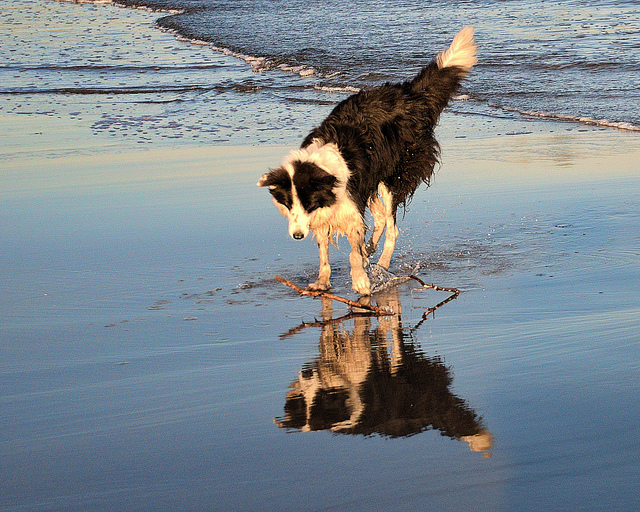

In [96]:
# Visualizamos la imagen cargada
Image ('example.jpg',
      width = 1200)

* Evaluación del modelo:

In [25]:
	
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
  all_features = load(open(filename, 'rb'))
	# filter features
  features = {k: all_features[k] for k in dataset}
  return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)
 
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
  # seed the generation process
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
    yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
    yhat = argmax(yhat)
		# map integer to word
    word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
    if word is None:
      break
		# append as input for generating the next word
    in_text += ' ' + word
		# stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text
 
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()
	# step over the whole set
  for key, desc_list in descriptions.items():
		# generate description
    yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# prepare tokenizer on train set
 
# load training dataset (6K)
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# prepare test set
 
# load test set
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = 'vgg16_gru_100.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 3857
Description Length: 30
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.309842
BLEU-2: 0.131033
BLEU-3: 0.089474
BLEU-4: 0.036951


* Generate new captions

In [33]:
ls -la

total 4328188
drwxr-xr-x 1 root root       4096 Feb  3 10:31 ./
drwxr-xr-x 1 root root       4096 Feb  3 08:08 ../
-rw-r--r-- 1 root root    7802308 Feb  3 10:33 11293289843_831b538448_o.jpg
drwxr-xr-x 4 root root       4096 Jan 31 17:14 .config/
-rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 root root     587144 Feb  3 08:12 descriptions.txt
-rw-r--r-- 1 root root     315475 Feb  3 10:08 example.jpg
-rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
-rw-r--r-- 1 root root 3248566509 Feb  3 08:27 features.pkl
drwxr-xr-x 2 root root     458752 Oct  3  2012 Flicker8k_Dataset/
-rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
-rw-r--r-- 1 

In [27]:
from keras.preprocessing.text import Tokenizer
from pickle import dump
 
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
		# get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
			# wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
      descriptions[image_id].append(desc)
  return descriptions
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
 
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [30]:
	
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
  #model = VGG16()
  in_layer = Input(shape=(224, 224, 3))      
  model = VGG16(include_top=False, input_tensor=in_layer)
	# re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
  image = load_img(filename, target_size=(224, 224))
  
	# convert the image pixels to a numpy array
  image = img_to_array(image)
  
	# reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  
	# prepare the image for the VGG model
  image = preprocess_input(image)
	# get features
  feature = model.predict(image, verbose=0)
  return feature

 
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
  in_text = 'startseq'
	# iterate over the whole length of the sequence
  for i in range(max_length):
  	# integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
    yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
    yhat = argmax(yhat)
		# map integer to word
    word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
    if word is None:
      break
		# append as input for generating the next word
    in_text += ' ' + word
		# stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 30
# load the model
model = load_model('vgg16_gru_100.h5')
# load and prepare the photograph
photo = extract_features('example.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq black and white dog is carrying toy in the water endseq


In [34]:
# Visualizamos la imagen cargada
Image ('11293289843_831b538448_o.jpg',
      width = 1200)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
  #model = VGG16()
  in_layer = Input(shape=(224, 224, 3))      
  model = VGG16(include_top=False, input_tensor=in_layer)
	# re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
  image = load_img(filename, target_size=(224, 224))
  
	# convert the image pixels to a numpy array
  image = img_to_array(image)
  
	# reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  
	# prepare the image for the VGG model
  image = preprocess_input(image)
	# get features
  feature = model.predict(image, verbose=0)
  return feature

 
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
  in_text = 'startseq'
	# iterate over the whole length of the sequence
  for i in range(max_length):
  	# integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
    yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
    yhat = argmax(yhat)
		# map integer to word
    word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
    if word is None:
      break
		# append as input for generating the next word
    in_text += ' ' + word
		# stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 30
# load the model
model = load_model('vgg16_gru_100.h5')
# load and prepare the photograph
photo = extract_features('11293289843_831b538448_o.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq dear dog on tree endseq


## Experimento 5: Modificación de: nº de épocas  y nº de batches por época en experimento con mejor accuracy

In [0]:
# Importamos las librerías que necesitamos
from os import listdir
from pickle import load, dump
from tqdm import tqdm
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu    
from keras.preprocessing.text import Tokenizer        
from keras.preprocessing.sequence import pad_sequences         
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Embedding, GRU
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D

In [0]:
# Empezamos con la extracción de características
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))      
    model = VGG16(include_top=False, input_tensor=in_layer)
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    # extract features from each photo.
    features = dict()

    files_in_directory = listdir(directory)     
    n_images = len(files_in_directory)
    for i, name in tqdm(enumerate(files_in_directory)): 
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array. Convertimos las imagenes a array
        image = img_to_array(image)
        # reshape data for the model. Añadimos la dimensión del batch
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model. Preprocesar la imagen
        image = preprocess_input(image)
        # get features. Le decimos que coja la imagen, la pase por la cnn y nos dé las predicciones. En feature tendremos el conjunto de mapas de activaciones
        feature = model.predict(image, verbose=0)
        # get image id. Miramos el id de la imagen
        image_id = name.split('.')[0]
        # store feature. Se lo metemos en el diccionario
        features[image_id] = feature
        # print('{} / {} > {}'.format(i, n_images, name))
    return features          


# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb')) 

In [0]:
from pickle import load

# load doc into memory. Cargamos nuestro documento limpio
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Carga de los id de las fotos
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # De las que no esten vacías cogemos el identificador
        identifier = line.split('.')[0]        
        dataset.append(identifier)
        # Obtenemos un set con cada uno de los identificadores de las fotos que hay
    return set(dataset)                                     


# load clean descriptions into memory. Esta función carga las descripciones limpias
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space. Divide las líneas por espacio
        tokens = line.split()
        # split id from description. Se queda como primer elemento como id y con todos los demás que son la descripción de imagen
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set. Si el id de la imagen aparece en el dataset
        if image_id in dataset:
            # store. Añadimos la descripción
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

# load photo features. Carga las características para una determinada foto
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features


In [0]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

In [0]:
# Ahora codificamos nuestras descripciones a números
from keras.preprocessing.text import Tokenizer

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

In [0]:
# Creamos las secuencias con las que se creará el modelo

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y) . y: etiqueta
    return [Ximages, XSeq, y]

In [0]:
# define the captioning model. Definimos: vocab_size --> tño de nuestro vocabulario, max_length --> tño max de las descripciones que queremos que genere
def define_model(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(7, 7, 512))         
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)        
	# embedding. Pasamos de palabras a números. Cosas que entienda la LSTM
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)      
	emb3 = GRU(256, return_sequences=True)(emb2)      
	emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)   
	# merge inputs
	merged = concatenate([fe3, emb4])    
	# language model (decoder)
	lm2 = GRU(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
	outputs = Dense(vocab_size, activation='softmax')(lm3)      
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)            
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])         
	print(model.summary())
	return model  

In [0]:
# map an integer to a word. Permite mapear de un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image. Genera una descripción para una imagen, en la forma que la red la necesita
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq' 
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)          
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word                           
        # stop if we predict the end of the sequence
        if word == 'endseq':           
            break
    return in_text
 
# evaluate the skill of the model. Función que nos permite evaluar la precisión de nuestro modelo
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score. BLEU es una métrica que se usa en NLP. Mide como de bueno es la predicción
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [44]:
# Carga de imágenes de training
filenameTrain = 'Flickr_8k.trainImages.txt'
datasetTrain = load_set(filenameTrain)
print('Dataset: %d' % len(datasetTrain))


# Carga de imágenes de test
filenameTest = 'Flickr_8k.testImages.txt'
datasetTest = load_set(filenameTest)
print('Dataset: %d' % len(datasetTest))

# descripciones
train_descriptions = load_clean_descriptions('descriptions.txt', datasetTrain)
test_descriptions = load_clean_descriptions('descriptions.txt', datasetTest)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions),len(test_descriptions)))

# Carga de características de mapas de activación (asociadas a imagenes de Train y de Test)
train_features = load_photo_features('features.pkl', datasetTrain)
test_features = load_photo_features('features.pkl', datasetTest)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)
 
# define experiment
model_name = 'vgg16_gru_200ep'
verbose = 1
n_epochs = 200
n_photos_per_update = 60
n_batches_per_epoch = int(len(datasetTrain) / n_photos_per_update)

 
# run experiment
train_results, test_results = list(), list()

# define the model
model = define_model(vocab_size, max_length)


# fit model
model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
# evaluate model on training data
train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

# store
train_results.append(train_score)
test_results.append(test_score)



Dataset: 6000
Dataset: 1000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000
Vocabulary Size: 3857
Description Length: 30
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 512)          0           input_7[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 50)       192850      inpu

In [45]:
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

          train      test
count  1.000000  1.000000
mean   0.407014  0.036642
std         NaN       NaN
min    0.407014  0.036642
25%    0.407014  0.036642
50%    0.407014  0.036642
75%    0.407014  0.036642
max    0.407014  0.036642


In [46]:
ls -la

total 1896160
drwxr-xr-x 1 root root       4096 Jan 30 13:58 ./
drwxr-xr-x 1 root root       4096 Jan 30 06:10 ../
drwxr-xr-x 4 root root       4096 Jan 28 17:05 .config/
-rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 root root     587144 Jan 30 08:23 descriptions.txt
-rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
-rw-r--r-- 1 root root  812722413 Jan 30 08:30 features.pkl
drwxr-xr-x 2 root root     409600 Jan 30 08:25 Flicker8k_Dataset/
-rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
-rw-r--r-- 1 root root    3395237 Oct 14  2013 Flickr8k.token.txt
-rw-r--r-- 1 root root     154678 Oct 10  2013 Flickr_8k.trainImages.txt
drwxrwxr-

In [60]:
cat vgg16_gru_200ep.csv


train,test
0.4070144322167725,0.03664184161225633


In [61]:
train_results

[0.4070144322167725]

## Conclusiones

Condiciones experimentales:
> 	* nº épocas: 100
    * nº de fotos por actualización: 60
    * nº batches por época: 6000/60 = 100

*	A medida que aumenta el nº de épocas, aumenta el accuracy y disminuye la función de pérdidas.
*	El valor máximo del accuracy obtenido en los diferentes experimentos es:


|                  |                                                                |         CNN                              |
|----------------|-----------------------------------------------------------------------------------------------------|
|                  |                              |  **VGG16**          |     **  ResNet 50**                |
| **RNN** |      **LSTM**       |      0.5962              |           0.6256                         |
|                  |       **GRU**        |      0.6854              |           0.5898                         |

Observamos que en el Experimento 4: VGG16 – GRU obtenemos los mejores resultado de accuracy = 0. 6854 con una función de pérdidas loss = 1.0282

* Las ventajas de usar una RNN GRU vs LSTM son las siguientes:






1.   Una red GRU tiene 2 puertas mientras que una red LSTM tiene 3 puertas (gates)
2.   GRU no posee una memoria interna (ct) que es diferente de lo expuesto en los estados ocultos. GRU no posee la salida de la puerta que está presente en LSTM.

1.   GRU es una representación más simplificada de LSTM y son más baratas de correr ( aunque ellas no puedan tener tanta potencia representacional como LSTM)
2.   En GRU los input y las puertas del olvido (forget gates) están actualizadas por una puerta (gate z) y el reset gate r es aplicado directamente al estado previo oculto. Así la responsabilidad del reset gate en una LSTM está realmente repartido entre r y z en GRU.











*	Por otra parte, en el experimento que obtuvimos mejor accuracy (Red VGG16 – GRU) realizamos un ajuste aumentando el nº de épocas a 200. Observamos una mejora de la accuracy en un 20%  (accuracy obtenida con 200 épocas para una red VGG16 – GRU: 0.8496).
*	Los resultados de image captioning obtenidos en el experimento 4 (Red VGG16 – GRU) tiene resultados muy dispares en cuanto a las frases de descripción proporcionadas:


1.  example.jpg -> black and white dog is carrying toy in the water  : descripción aceptable en un 80% aproximadamente
2.  11293289843_831b538448_o.jpg -> dear dog on tree: descripción que no se acerca a la realidad ya que es un perro al lado de un árbol y un lago

Podríamos mejorar este Image captioning por un aumento en el nº de épocas y/o por alguna modificación recogida en Próximos pasos.





*	Próximos pasos: Posibles experimentos para obtener una red CNN – RNN que obtengan mejores resultados de aumento el accuracy y disminución de la función de perdidas estarían en la línea de:


1.   Cambio en el número de capas en la GRU
2.   Variar el internal state-size


3.   Variar los embedding-size
4.   Empleo de otra capa de transferencia en el modelo VGG 16, por ejemplo emplear una capa flattened output en la última capa convolucional.


5.   Desarrollo de un experimento end-to-end para ver los resultados que proporcionan.






 LSTM: Long Short Term Memory

GRU: Gated Recurrent Units

VGG 16 : Visual Geometry Group
